When a user plays Hangman, the server first selects a secret word at random from a list. The server then returns a row of underscores (space separated)—one for each letter in the secret word—and asks the user to guess a letter. If the user guesses a letter that is in the word, the word is redisplayed with all instances of that letter shown in the correct positions, along with any letters correctly guessed on previous turns. If the letter does not appear in the word, the user is charged with an incorrect guess. The user keeps guessing letters until either (1) the user has correctly guessed all the letters in the word
or (2) the user has made six incorrect guesses.

You are required to write a "guess" function that takes current word (with underscores) as input and returns a guess letter. You will use the API codes below to play 1,000 Hangman games. You have the opportunity to practice before you want to start recording your game results.

Your algorithm is permitted to use a training set of approximately 250,000 dictionary words. Your algorithm will be tested on an entirely disjoint set of 250,000 dictionary words. Please note that this means the words that you will ultimately be tested on do NOT appear in the dictionary that you are given. You are not permitted to use any dictionary other than the training dictionary we provided. This requirement will be strictly enforced by code review.

You are provided with a basic, working algorithm. This algorithm will match the provided masked string (e.g. a _ _ l e) to all possible words in the dictionary, tabulate the frequency of letters appearing in these possible words, and then guess the letter with the highest frequency of appearence that has not already been guessed. If there are no remaining words that match then it will default back to the character frequency distribution of the entire dictionary.

This benchmark strategy is successful approximately 18% of the time. Your task is to design an algorithm that significantly outperforms this benchmark.

In [1]:
import json
import requests
import random
import string
import secrets
import time
import re
import collections
try:
    from urllib.parse import parse_qs, urlencode, urlparse
except ImportError:
    from urlparse import parse_qs, urlparse
    from urllib import urlencode

### Exploratory Data Analysis

In [20]:
# Word length distribution
from tqdm import tqdm
full_dictionary_location = "words_250000_train.txt"
full_dictionary = api.build_dictionary(full_dictionary_location) 
full_dictionary
word_length_dict = dict()
for i in tqdm(range(0, len(full_dictionary))):
    length = len(full_dictionary[i])
    if length not in word_length_dict.keys():
        word_length_dict[length] = 1
    else:
        word_length_dict[length] += 1

100%|██████████| 227300/227300 [00:00<00:00, 866859.64it/s]


<BarContainer object of 28 artists>

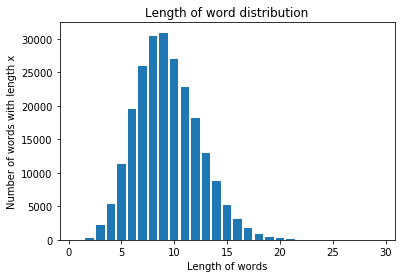

In [24]:
import matplotlib.pyplot as plt
plt.bar(word_length_dict.keys(), word_length_dict.values())
plt.xlabel("Length of words")
plt.ylabel("Number of words with length x")
plt.title("Length of word distribution")
plt.show()

# we can see that the number of letters with the most frequency is 9

##### There are 2 modes for my algorithm. The first mode takes frequency, wrong guesses and length of word into account. The second mode uses conditional probability based on letter positioning. The mode switches from first to second based on length_of_word*2/9 rounded up number of blanks left.

In [312]:
for i in range(2, 21+1):
    target = math.ceil(i*1/3)
    print('For length', i, 'word, the number of blanks left to switch to conditional probability at is:', target)

For length 2 word, the number of blanks left to switch to conditional probability at is: 1
For length 3 word, the number of blanks left to switch to conditional probability at is: 1
For length 4 word, the number of blanks left to switch to conditional probability at is: 2
For length 5 word, the number of blanks left to switch to conditional probability at is: 2
For length 6 word, the number of blanks left to switch to conditional probability at is: 2
For length 7 word, the number of blanks left to switch to conditional probability at is: 3
For length 8 word, the number of blanks left to switch to conditional probability at is: 3
For length 9 word, the number of blanks left to switch to conditional probability at is: 3
For length 10 word, the number of blanks left to switch to conditional probability at is: 4
For length 11 word, the number of blanks left to switch to conditional probability at is: 4
For length 12 word, the number of blanks left to switch to conditional probability at is

In [384]:
HANGMAN_URL = "https://www.trexsim.com/trexsim/hangman"

class HangmanAPI(object):
    def __init__(self, access_token=None, session=None, timeout=None):
        self.access_token = access_token
        self.session = session or requests.Session()
        self.timeout = timeout
        self.guessed_letters = []
        
        full_dictionary_location = "words_250000_train.txt"
        self.full_dictionary = self.build_dictionary(full_dictionary_location)        
        self.full_dictionary_common_letter_sorted = collections.Counter("".join(self.full_dictionary)).most_common()
        
        self.current_dictionary = full_dictionary
        self.fraction_of_blanks = 1/2
    
    def initial_dictionary(self, word):
        
        init_dict = []
        l = len(word)
        for word in self.current_dictionary:
            if len(word) == l:
                init_dict.append(word)
            elif len(word) > l:
                for i in range(0, len(word)-l+1):
                    letter_group = word[i:i+l]
                    init_dict.append(letter_group)
                    
        self.current_dictionary = init_dict
        
    def revise_dictionary(self, word):
        
        initial_dict = self.current_dictionary
        guessed_letters = self.guessed_letters
        wrong_letters = []
        for gl in guessed_letters:
            if gl not in word:
                wrong_letters.append(gl)
        
        if len(self.guessed_letters) > 0:
            revised_dictionary = []
            for word in initial_dict:
                if any(letter in wrong_letters for letter in word) == False:
                    revised_dictionary.append(word)
        
            self.current_dictionary = revised_dictionary
            
    def short_words_dictionary(self, word):
        
        initial_dict = self.current_dictionary
        if word.count('.') < len(word): # there are guessed letters
            
            #get position of those guessed letters
            positions = []
            letters = []
            index = 0
            for letter in word:
                if letter != '.':
                    positions.append(index)
                    letters.append(letter)
                index += 1
                
            short_words_dict = []
            for word in initial_dict:
                boolean = []
                for i in range(0, len(positions)):
                    pos = positions[i]
                    if word[pos] == letters[i]:
                        boolean.append(1)
                
                if sum(boolean) == len(positions):
                    short_words_dict.append(word)
            
            self.current_dictionary = short_words_dict
        
    def first_guesses(self, word, short_word=0):
        
        dictionary = self.current_dictionary
        import string
        alphabets = list(string.ascii_lowercase)
        frequency_dictionary = dict()
        for alphabet in alphabets:
            frequency_dictionary[alphabet] = 0
        
        if short_word == 1:
            self.short_words_dictionary(word)
        self.revise_dictionary(word)
        
        for word in self.current_dictionary:
            unique_letters = list(set(word)) # if word has 2 's', we only count if word includes 's' or not
            for letter in unique_letters:
                frequency_dictionary[letter] += 1
        
        for key in list(frequency_dictionary.keys()):
            if key in self.guessed_letters:
                del frequency_dictionary[key]
        
        letter_to_guess = max(frequency_dictionary, key = lambda key: frequency_dictionary[key])
        
        return letter_to_guess
    
    def get_highest_freq(self, temp_dict):
        
        import string
        alphabets = list(string.ascii_lowercase)
        frequency_dictionary = dict()
        for alphabet in alphabets:
            frequency_dictionary[alphabet] = 0
        for letter in temp_dict:
            frequency_dictionary[letter] += 1

        for key in list(frequency_dictionary.keys()):
            if key in self.guessed_letters:
                del frequency_dictionary[key]

        letter_to_guess = max(frequency_dictionary, key = lambda key: frequency_dictionary[key])
        
        return letter_to_guess, frequency_dictionary[letter_to_guess]
        
    def subq_guesses_THREE(self, word, target, len_grp_letters):
        
        # identify positions of blanks
        l = len(word)
        positions = []
        index = 0
        for i in range(0, len(word)):
            if word[i] == '.':
                positions.append(index)
            index += 1
                
        shorter_revised_dictionary = []
        for word_ in self.full_dictionary: #revised_dictionary:
            if len(word_) >= len_grp_letters:
                for i in range(0, len(word_)-len_grp_letters+1):
                    letter_grp = word_[i:i+len_grp_letters]
                    shorter_revised_dictionary.append(letter_grp)
        # print(shorter_revised_dictionary[:10])
        
        # already got dict and position of blanks, now time to get conditional probability
        freq_df = pd.DataFrame(columns=['Conditional', 'Letter', 'Frequency'])
        if l >= len_grp_letters:
            positions = list(positions)
            # print(positions)
            for i in range(0, len(positions)):
                pos = positions[i]
                # print('Assessing position', pos, 'letter', word[pos])
                if pos == 0 and word[1:3].isalpha():
                    to_grab_on_right = len_grp_letters - 1
                    letter_grp = '_'+word[pos+1:pos+3]
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[0] for word in shorter_revised_dictionary if word[1:] == letter_grp[1:]]
                    #print(temp_dict[:50])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                    
                if pos > 0 and pos < l-1 and word[pos-1].isalpha() and word[pos+1].isalpha():
                    to_grab_on_lr = len_grp_letters - 2
                    letter_grp_l = word[pos-1]
                    letter_grp_r = word[pos+1]
                    letter_grp = letter_grp_l + '_' + letter_grp_r
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[1] for word in shorter_revised_dictionary if word[0] == letter_grp_l and word[2] == letter_grp_r]
                    #print(temp_dict[:50])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                    
                if pos > 1 and pos < l-1 and word[pos-2].isalpha() and word[pos-1].isalpha():
                    to_grab_on_left = len_grp_letters - 1
                    letter_grp = word[pos-2:pos-1+1]+'_'
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[2] for word in shorter_revised_dictionary if word[:-1] == letter_grp[:-1]]
                    #print(temp_dict[:50])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                    
                if pos > 0 and pos < l-2 and word[pos+1].isalpha() and word[pos+2].isalpha():
                    to_grab_on_right = len_grp_letters - 1
                    letter_grp = '_'+word[pos+1:pos+2+1]
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[0] for word in shorter_revised_dictionary if word[1:] == letter_grp[1:]]
                    #print(temp_dict[:50])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                    
                if pos == l-1 and word[pos-3:pos-1].isalpha():
                    to_grab_on_left = len_grp_letters - 1
                    letter_grp = word[l-2-1:l-1]+'_'
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[2] for word in shorter_revised_dictionary if word[:-1] == letter_grp[:-1]]
                    #print(temp_dict[:50])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                
        if len(freq_df) > 0:
            sorted_df = freq_df.sort_values(by=['Frequency'])
            # print('Sorted conditional probability frequency table is:', sorted_df)
            return sorted_df['Letter'].values[-1]
        else:
            return 0
    
    def subq_guesses_FOUR(self, word, target, len_grp_letters):
        
        # identify positions of blanks
        l = len(word)
        positions = []
        index = 0
        for i in range(0, len(word)):
            if word[i] == '.':
                positions.append(index)
            index += 1
        
        shorter_revised_dictionary = []
        for word_ in self.full_dictionary: #revised_dictionary:
            if len(word_) >= len_grp_letters:
                for i in range(0, len(word_)-len_grp_letters+1):
                    letter_grp = word_[i:i+len_grp_letters]
                    shorter_revised_dictionary.append(letter_grp)
        
        # already got dict and position of blanks, now time to get conditional probability
        freq_df = pd.DataFrame(columns=['Conditional', 'Letter', 'Frequency'])
        if l >= len_grp_letters:
            positions = list(positions)
            #print(positions)
            for i in range(0, len(positions)):
                pos = positions[i]
                # print('Assessing position', pos, 'letter', word[pos])
                if pos == 0 and word[1:4].isalpha():
                    to_grab_on_right = len_grp_letters - 1
                    letter_grp = '_'+word[pos+1:pos+4]
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[0] for word in shorter_revised_dictionary if word[1:] == letter_grp[1:]]
                    #print([word for word in shorter_revised_dictionary if word[1:] == letter_grp[1:]][:10])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                
                #x111
                if pos > 0 and pos < l-3 and word[pos+1:pos+4].isalpha(): 
                    to_grab_on_right = len_grp_letters - 1
                    letter_grp = '_'+word[pos+1:pos+4]
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[0] for word in shorter_revised_dictionary if word[1:] == letter_grp[1:]]
                    #print([word for word in shorter_revised_dictionary if word[1:] == letter_grp[1:]][:10])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                
                #1x11
                if pos > 0 and pos < l-2 and word[pos-1].isalpha() and word[pos+1:pos+3].isalpha():
                    to_grab_on_lr = len_grp_letters - 2
                    letter_grp_l = word[pos-1] # LHS = 1
                    letter_grp_r = word[pos+1:pos+3] # RHS = 2
                    letter_grp = letter_grp_l + '_' + letter_grp_r
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[1] for word in shorter_revised_dictionary if word[0] == letter_grp_l and word[2:4] == letter_grp_r]
                    #print([word for word in shorter_revised_dictionary if word[0] == letter_grp_l and word[2:4] == letter_grp_r][:10])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                
                #11x1
                if pos > 1 and pos < l-1 and word[pos-2:pos].isalpha() and word[pos+1].isalpha():
                    to_grab_on_left = len_grp_letters - 1
                    letter_grp_l = word[pos-2:pos] # LHS = 2
                    letter_grp_r = word[pos+1] # RHS = 1
                    letter_grp = letter_grp_l+'_'+letter_grp_r
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[2] for word in shorter_revised_dictionary if word[0:2] == letter_grp_l and word[-1] == letter_grp_r]
                    #print([word for word in shorter_revised_dictionary if word[0:2] == letter_grp_l and word[-1] == letter_grp_r][:10])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                
                #111x
                if pos > 2 and pos < l-1 and word[pos-3:pos].isalpha():
                    to_grab_on_right = len_grp_letters - 1
                    letter_grp = word[pos-3:pos]+'_'
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[-1] for word in shorter_revised_dictionary if word[:-1] == letter_grp[:-1]]
                    #print([word for word in shorter_revised_dictionary if word[:-1] == letter_grp[:-1]][:10])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                
                #111x and at the end
                if pos == l-1 and word[pos-3:pos].isalpha():
                    to_grab_on_left = len_grp_letters - 1
                    letter_grp = word[pos-3:pos]+'_'
                    #print('Letter group is:', letter_grp)
                    temp_dict = [word[3] for word in shorter_revised_dictionary if word[:-1] == letter_grp[:-1]]
                    #print([word for word in shorter_revised_dictionary if word[:-1] == letter_grp[:-1]][:10])
                    ltg,freq = self.get_highest_freq(temp_dict)
                    new_row = {'Conditional': letter_grp,
                               'Letter':      ltg,
                               'Frequency':   freq}
                    freq_df = freq_df.append(new_row, ignore_index=True)
                
        if len(freq_df) > 0:
            sorted_df = freq_df.sort_values(by=['Frequency'])
            #print('Sorted conditional probability frequency table is:', sorted_df)
            return sorted_df['Letter'].values[-1]
        else:
            return 0
        
    def guess(self, word): # word input example: "_ p p _ e "
        
        # initialize first dictionary
        clean_word = word[::2].replace("_",".")
        l = len(clean_word)
        self.initial_dictionary(clean_word)
        no_of_blanks = clean_word.count('.')
        import math
        target = math.ceil(l*self.fraction_of_blanks)
        #print('Target to switch is:', target)
        
        if l == 3:
            
            if no_of_blanks == 1:
                guess_letter = self.first_guesses(clean_word)
            else:
                guess_letter = self.subq_guesses_THREE(clean_word, target, 3)
                
        elif 1 < 10:
            
            if no_of_blanks > target:

                guess_letter = self.first_guesses(clean_word, short_word=1)
            
            else: # when left with few blanks, time to call on conditional probability
                #print('Conditional Probability mode on!')
                guess_letter = self.subq_guesses_FOUR(clean_word, target, 4)
                if guess_letter == 0:
                    #print('No combinations of 4.')
                    guess_letter = self.subq_guesses_THREE(clean_word, target, 3)
                    if guess_letter == 0:
                        #print('No combinations of 3.')
                        guess_letter = self.first_guesses(clean_word)
             
        else:
            if no_of_blanks > target:

                guess_letter = self.first_guesses(clean_word)
            
            else: # when left with few blanks, time to call on conditional probability
                #print('Conditional Probability mode on!')
                guess_letter = self.subq_guesses_FOUR(clean_word, target, 4)
                if guess_letter == 0:
                    #print('No combinations of 4.')
                    guess_letter = self.subq_guesses_THREE(clean_word, target, 3)
                    if guess_letter == 0:
                        #print('No combinations of 3.')
                        guess_letter = self.first_guesses(clean_word)
        
        return guess_letter
        

    ##########################################################
    # You'll likely not need to modify any of the code below #
    ##########################################################
    
    def build_dictionary(self, dictionary_file_location):
        text_file = open(dictionary_file_location,"r")
        full_dictionary = text_file.read().splitlines()
        text_file.close()
        return full_dictionary
                
    def start_game(self, practice=True, verbose=True):
        # reset guessed letters to empty set and current plausible dictionary to the full dictionary
        self.guessed_letters = []
        self.current_dictionary = self.full_dictionary
                         
        response = self.request("/new_game", {"practice":practice})
        if response.get('status')=="approved":
            game_id = response.get('game_id')
            word = response.get('word')
            tries_remains = response.get('tries_remains')
            if verbose:
                print("Successfully start a new game! Game ID: {0}. # of tries remaining: {1}. Word: {2}.".format(game_id, tries_remains, word))
            while tries_remains>0:
                # get guessed letter from user code
                guess_letter = self.guess(word)
                    
                # append guessed letter to guessed letters field in hangman object
                self.guessed_letters.append(guess_letter)
                if verbose:
                    print("Guessing letter: {0}".format(guess_letter))
                    
                try:    
                    res = self.request("/guess_letter", {"request":"guess_letter", "game_id":game_id, "letter":guess_letter})
                except HangmanAPIError:
                    print('HangmanAPIError exception caught on request.')
                    continue
                except Exception as e:
                    print('Other exception caught on request.')
                    raise e
               
                if verbose:
                    print("Sever response: {0}".format(res))
                status = res.get('status')
                tries_remains = res.get('tries_remains')
                if status=="success":
                    if verbose:
                        print("Successfully finished game: {0}".format(game_id))
                    return True
                elif status=="failed":
                    reason = res.get('reason', '# of tries exceeded!')
                    if verbose:
                        print("Failed game: {0}. Because of: {1}".format(game_id, reason))
                    return False
                elif status=="ongoing":
                    word = res.get('word')
        else:
            if verbose:
                print("Failed to start a new game")
        return status=="success"
        
    def my_status(self):
        return self.request("/my_status", {})
    
    def request(
            self, path, args=None, post_args=None, method=None):
        if args is None:
            args = dict()
        if post_args is not None:
            method = "POST"

        # Add `access_token` to post_args or args if it has not already been
        # included.
        if self.access_token:
            # If post_args exists, we assume that args either does not exists
            # or it does not need `access_token`.
            if post_args and "access_token" not in post_args:
                post_args["access_token"] = self.access_token
            elif "access_token" not in args:
                args["access_token"] = self.access_token

        try:
            # response = self.session.request(
            response = requests.request(
                method or "GET",
                HANGMAN_URL + path,
                timeout=self.timeout,
                params=args,
                data=post_args)
        except requests.HTTPError as e:
            response = json.loads(e.read())
            raise HangmanAPIError(response)

        headers = response.headers
        if 'json' in headers['content-type']:
            result = response.json()
        elif "access_token" in parse_qs(response.text):
            query_str = parse_qs(response.text)
            if "access_token" in query_str:
                result = {"access_token": query_str["access_token"][0]}
                if "expires" in query_str:
                    result["expires"] = query_str["expires"][0]
            else:
                raise HangmanAPIError(response.json())
        else:
            raise HangmanAPIError('Maintype was not text, or querystring')

        if result and isinstance(result, dict) and result.get("error"):
            raise HangmanAPIError(result)
        return result
    
class HangmanAPIError(Exception):
    def __init__(self, result):
        self.result = result
        self.code = None
        try:
            self.type = result["error_code"]
        except (KeyError, TypeError):
            self.type = ""

        try:
            self.message = result["error_description"]
        except (KeyError, TypeError):
            try:
                self.message = result["error"]["message"]
                self.code = result["error"].get("code")
                if not self.type:
                    self.type = result["error"].get("type", "")
            except (KeyError, TypeError):
                try:
                    self.message = result["error_msg"]
                except (KeyError, TypeError):
                    self.message = result

        Exception.__init__(self, self.message)

# API Usage Examples

## To start a new game:
1. Make sure you have implemented your own "guess" method.
2. Use the access_token that we sent you to create your HangmanAPI object. 
3. Start a game by calling "start_game" method.
4. If you wish to test your function without being recorded, set "practice" parameter to 1.
5. Note: You have a rate limit of 20 new games per minute. DO NOT start more than 20 new games within one minute.

In [385]:
api = HangmanAPI(access_token="4c16ca9a19fc7e3acc9ef114ffd7d1", timeout=2000)

## Playing practice games:
You can use the command below to play up to 100,000 practice games.

In [386]:
api.start_game(practice=1,verbose=True)
[total_practice_runs,total_recorded_runs,total_recorded_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
print('run %d practice games out of an allotted 100,000' %total_practice_runs)

Successfully start a new game! Game ID: bca9e6e5f120. # of tries remaining: 6. Word: _ _ _ _ _ _ _ _ _ .
Guessing letter: i
Sever response: {'game_id': 'bca9e6e5f120', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ _ _ _ _ i _ _ _ '}
Guessing letter: e
Sever response: {'game_id': 'bca9e6e5f120', 'status': 'ongoing', 'tries_remains': 6, 'word': '_ e _ _ _ i _ _ e '}
Guessing letter: r
Sever response: {'game_id': 'bca9e6e5f120', 'status': 'ongoing', 'tries_remains': 6, 'word': 'r e _ _ _ i _ _ e '}
Guessing letter: s
Sever response: {'game_id': 'bca9e6e5f120', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e _ _ _ i _ _ e '}
Guessing letter: d
Sever response: {'game_id': 'bca9e6e5f120', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e _ _ d i _ _ e '}
Guessing letter: a
Sever response: {'game_id': 'bca9e6e5f120', 'status': 'ongoing', 'tries_remains': 5, 'word': 'r e _ _ d i a _ e '}
Guessing letter: t
Sever response: {'game_id': 'bca9e6e5f120', 'status': 'ongoing', 'tries_

## Playing recorded games:
Please finalize your code prior to running the cell below. Once this code executes once successfully your submission will be finalized. Our system will not allow you to rerun any additional games.

Please note that it is expected that after you successfully run this block of code that subsequent runs will result in the error message "Your account has been deactivated".

Once you've run this section of the code your submission is complete. Please send us your source code via email.

In [388]:
for i in range(1000):
    print('Playing ', i, ' th game')
    # Uncomment the following line to execute your final runs. Do not do this until you are satisfied with your submission
    api.start_game(practice=0,verbose=False)
    
    # DO NOT REMOVE as otherwise the server may lock you out for too high frequency of requests
    time.sleep(0.5)

Playing  0  th game
Playing  1  th game
Playing  2  th game
Playing  3  th game
Playing  4  th game
Playing  5  th game
Playing  6  th game
Playing  7  th game
Playing  8  th game
Playing  9  th game
Playing  10  th game
Playing  11  th game
Playing  12  th game
Playing  13  th game
Playing  14  th game
Playing  15  th game
Playing  16  th game
Playing  17  th game
Playing  18  th game
Playing  19  th game
Playing  20  th game
Playing  21  th game
Playing  22  th game
Playing  23  th game
Playing  24  th game
Playing  25  th game
Playing  26  th game
Playing  27  th game
Playing  28  th game
Playing  29  th game
Playing  30  th game
Playing  31  th game
Playing  32  th game
Playing  33  th game
Playing  34  th game
Playing  35  th game
Playing  36  th game
Playing  37  th game
Playing  38  th game
Playing  39  th game
Playing  40  th game
Playing  41  th game
Playing  42  th game
Playing  43  th game
Playing  44  th game
Playing  45  th game
Playing  46  th game
Playing  47  th game
Pl

HangmanAPIError: {'error': 'You have reached 1000 of games', 'status': 'denied'}

## To check your game statistics
1. Simply use "my_status" method.
2. Returns your total number of games, and number of wins.

In [389]:
[total_practice_runs,total_recorded_runs,total_recorded_successes] = api.my_status() # Get my game stats: (# of tries, # of wins)
success_rate = total_recorded_successes/total_recorded_runs
print('overall success rate = %.3f' % success_rate)

overall success rate = 0.367


In [390]:
total_recorded_runs

1000